まずはデータの確認・前処理をしていく

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns

In [2]:
# train test　はそれぞれ別々だが合体させてnanを補完する形とする

train = pd.read_csv("./input/titanic/train.csv")
test = pd.read_csv("./input/titanic/test.csv")
test["Survived"] = np.nan
titanic = pd.concat([train, test], ignore_index=True, sort=False)
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


----------------------------Age------------------------------------

年齢に欠損があるため、穴埋めする（欠損数：１７７）

SVRを使用し、年齢予測する

In [3]:
# Ageに空白のない要素を抽出、学習・評価に使用
# モデルの作成
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR

X0 = titanic[titanic["Age"].notnull()][["Pclass", "SibSp", "Parch", "Sex"]]
X = pd.get_dummies(X0, dtype="uint8")
y = titanic[titanic["Age"].notnull()]["Age"]

model = SVR(kernel="rbf", gamma=0.1, C=10)
cv_scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5)

np.mean(cv_scores)

-152.5951819650214

In [4]:
# 作成したモデルにて、欠損値の補完をする
age_nandata0 = titanic[titanic["Age"].isnull()][["Pclass", "SibSp", "Parch", "Sex"]]
age_nandata = pd.get_dummies(age_nandata0, dtype="uint8")
model.fit(X, y)
pred_age = model.predict(age_nandata)
titanic.loc[(titanic.Age.isnull()), "Age"] = pred_age
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

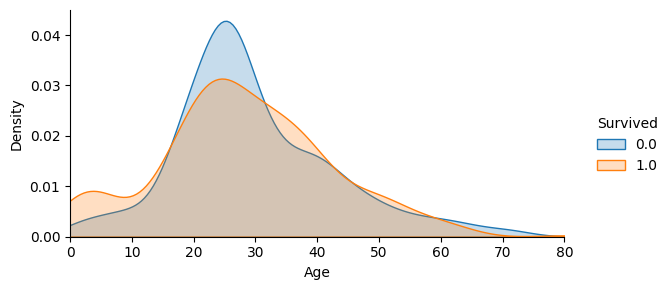

In [11]:
# 年齢別生存曲線と死亡曲線
plt.figure(layout="constrained")
facet = sns.FacetGrid(titanic[0:890], hue="Survived", aspect=2)
facet.map(sns.kdeplot, "Age", fill=True)
facet.set(xlim=(0, titanic.loc[0:890, "Age"].max()))
facet.add_legend()
facet.tight_layout()

---------------Name--------------